In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Line-of-sight velocity Measurements

So our code generated l-o-s velocity measurements for this version of Draco, with errors that correspond to being measured with IMACS, with a systematic velocity floor of 1 km/s. This galaxy has a systematic velocity of 60 km/s.

In [2]:
no=3
temp_=np.loadtxt(f"instance/temp_{no}.txt")

#RA  0      #DEC 1         #MAG_G  2     #MAG_I 3    
#ANGSEP 4   #RPROJ 5    
#SNR 6      #VTRUE 7       #VSTAT 8      #VSYS 9     
#VMEAS 10   #VMEASERR  11  #VSYSERR 12   #VERR 13 
nancut=~np.any(np.isnan(temp_),axis=-1)

temp_=temp_[nancut]
temp=temp_[:100*no].T
# the points need to be truncated for this analysis, read the README.md

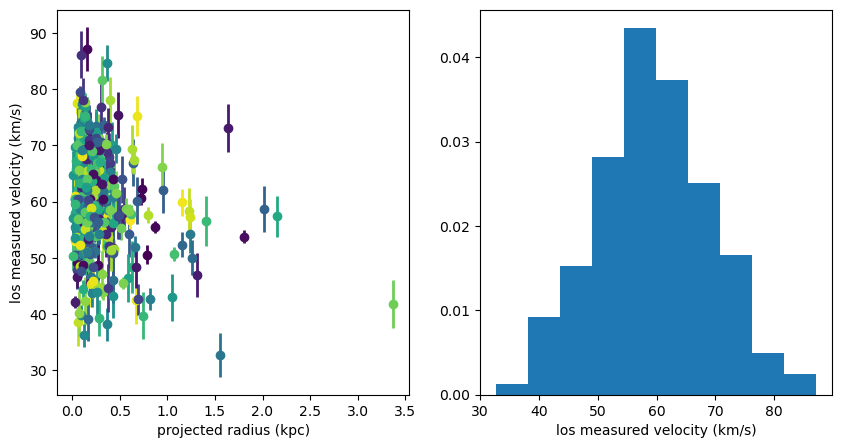

In [3]:
f,a=plt.subplots(1,2,figsize=(10,5))
#a[0].plot(temp[5],temp[10],marker='o',linewidth=0)
colors=plt.get_cmap('viridis')
ran=np.random.rand(len(temp[0]))
for c in range(len(ran)):
    a[0].errorbar(temp[5][c],temp[10][c],temp[13][c],marker='o',linewidth=0,elinewidth=2,color=colors(ran)[c])
a[0].set_xlabel('projected radius (kpc)')
a[0].set_ylabel('los measured velocity (km/s)')


a[1].hist(temp[10],density=True)
a[1].set_xlabel('los measured velocity (km/s)')
plt.show()

# Maximum Likelihood (frequentist)

We assume that the underlying distribution of these velocities is a gaussian with mean $\mu$ and dispersion $\sigma$. There is also a measurement error on each star of $e$, which means the errors are heteroscedastic. The data likelihood in this case is

\begin{align*}
\mathcal{L}=p(D | \mu,\sigma)&=\prod_{i=1}^{N} \frac{1}{\sqrt{2\pi}\sqrt{\sigma^2+e_i^2}} \exp \left(-\frac{(x_i-\mu)^2}{2(\sigma^2+e_i^2)}\right)
\end{align*}
Then we can maximize the log-likelihood to maximize the likelihood
\begin{align*}
\ln\mathcal{L}&=-\frac{N}{2}\ln(2\pi)-\frac{1}{2}\sum_{i=1}^{N} \ln\left(\sigma^2+e_i^2\right) -\frac{1}{2}\sum_{i=1}^{N} \frac{(x_i-\mu)^2}{(\sigma^2+e_i^2)}
\end{align*}

This derivation is reaffirmed in equation 8 of Walker et al 2007 (https://arxiv.org/pdf/astro-ph/0511465.pdf)

In [4]:
npts=1000
mu_=np.linspace(40,80,npts)
sg_=np.linspace(0.1,20,npts)

mu,sg=np.meshgrid(mu_,sg_)

errors=temp[13]
measvs=temp[10]


#ignoring the constant first term which depends on the # of points but is constant for any particular data realization

lnLi = [-0.5*np.log(sg**2+errors[i]**2)-0.5*(measvs[i]-mu)**2/(sg**2+errors[i]**2) for i in range(len(temp[13]))]
lnLi=np.array(lnLi)
lnL=np.sum(lnLi,axis=0)


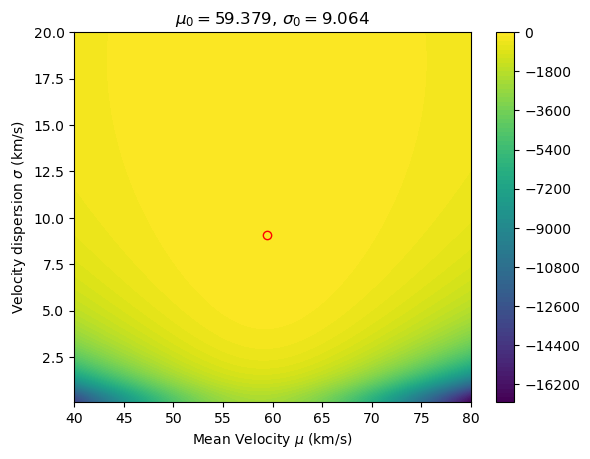

In [5]:
f,a=plt.subplots()

ind=np.unravel_index(lnL.argmax(), lnL.shape)

lnL=lnL-lnL[ind]
q=a.contourf(mu,sg,lnL,100)
a.plot(mu[ind],sg[ind],marker='o',markerfacecolor="None",markeredgecolor='red')
a.set_xlabel(r"Mean Velocity $\mu$ (km/s)")
a.set_ylabel(r"Velocity dispersion $\sigma$ (km/s)")
a.set_title(r"$\mu_0=$"+f"{mu[ind]:.3f}, " +r"$\sigma_0=$"+f"{sg[ind]:.3f}")
plt.colorbar(q)
plt.show()

# Bayesian Likelihood

Now instead of maximizing the data likelihood we maximize the posterior as:
\begin{align*}
p(\mu,\sigma | D)&=\frac{p( D|\mu,\sigma) p(\mu,\sigma)}{p(D)}
\end{align*}

And I think in this case we will assume that $p(\mu,\sigma)=p(\mu)p(\sigma)$ and because $\mu$ is a location parameter its prior is constant. Because $\sigma$ is a scale parameter, we will assume a prior of $1/\sigma$. Then

[[0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 ...
 [3.95570070e-107 6.99095758e-107 1.23406780e-106 ... 3.22536587e-114
  1.76414754e-114 9.63784490e-115]
 [4.12737718e-107 7.28630286e-107 1.28478478e-106 ... 3.47585799e-114
  1.90338774e-114 1.04107642e-114]
 [4.30354645e-107 7.58893371e-107 1.33667589e-106 ... 3.74287336e-114
  2.05200411e-114 1.12367939e-114]]
1825.7081419053154


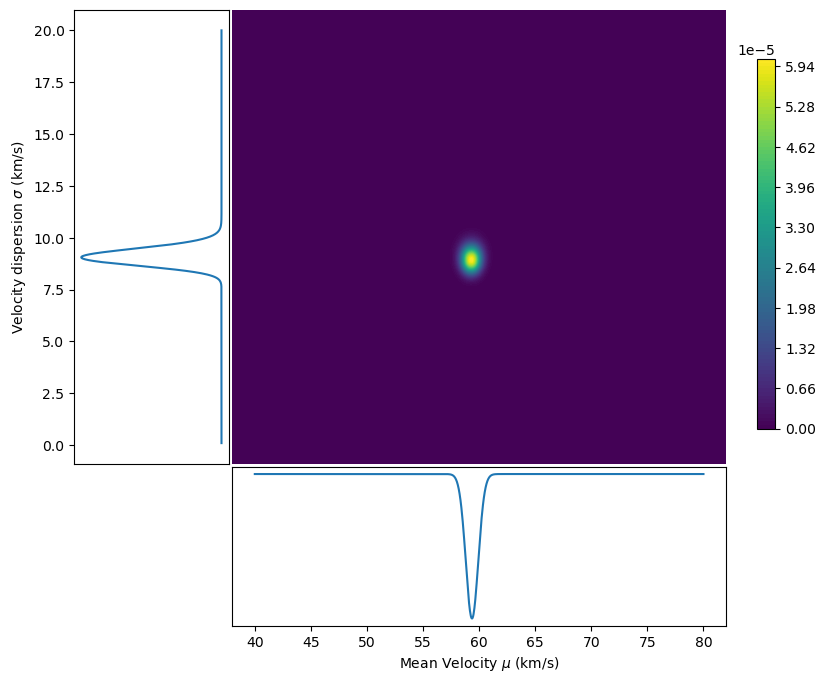

In [6]:
f,a=plt.subplots(2,2,figsize=(10,8),gridspec_kw={'width_ratios': [0.5, 2], 'height_ratios': [2,0.7]})

a[1,0].axis('off')
print(np.exp(lnL))
print(np.sum(np.exp(lnL)))
jpdf=np.exp(lnL)/np.sum(np.exp(lnL))/sg
q=a[0,1].contourf(mu,sg,jpdf,100)
a[0,1].axis('off')

marg_mu=np.sum(jpdf,axis=0)
a[1,1].plot(mu_,marg_mu)
a[1,1].set_xlabel(r"Mean Velocity $\mu$ (km/s)")
a[1,1].set_yticks([])
a[1,1].invert_yaxis()

marg_sg=np.sum(jpdf,axis=1)
a[0,0].plot(marg_sg,sg_)
a[0,0].set_ylabel(r"Velocity dispersion $\sigma$ (km/s)")
a[0,0].set_xticks([])
a[0,0].invert_xaxis()

plt.subplots_adjust(wspace=0.01,hspace=0.01)
f.colorbar(q, ax=a[:, 1], shrink=0.6,anchor=(0.0,0.8))
plt.show()

And I'm marginalizing over the parameters to get an uncertainty on the velocity dispersion

In [8]:
cdf_mu=np.cumsum(marg_mu)/np.sum(marg_mu)
cdf_sg=np.cumsum(marg_sg)/np.sum(marg_sg)

print(np.argmin( (cdf_mu-0.500)**2))

mu_med=mu_[np.argmin( (cdf_mu-0.500)**2)]
sg_med=sg_[np.argmin( (cdf_sg-0.500)**2)]
mu_upp=mu_[np.argmin( (cdf_mu-0.841)**2)]
sg_upp=sg_[np.argmin( (cdf_sg-0.841)**2)]
mu_low=mu_[np.argmin( (cdf_mu-0.159)**2)]
sg_low=sg_[np.argmin( (cdf_sg-0.159)**2)]

print(f'mu = {mu_med} + {mu_upp-mu_med} - {mu_med-mu_low}')
print(f'mu = {sg_med} + {sg_upp-sg_med} - {sg_med-sg_low}')

483
mu = 59.33933933933934 + 0.5605605605605604 - 0.5605605605605604
mu = 9.063963963963964 + 0.43823823823823815 - 0.39839839839839897


And the velocity dispersion is consistent with 9.1 ± 1.2 found in Walker et al 2009 (https://arxiv.org/pdf/0906.0341.pdf). Not specifically the uncertainty, because that measurement was made with M2FS and this simulation assumes a different number of stars. But you know, the point is that the simulation broadly kind of works and results in observations.

# The Question

Does increasing the number of stars observed, at the expense of the time each star is observed, decrease the uncertainty of the velocity dispersion?

In [9]:
mu_meds=[]
sg_meds=[]
mu_upps=[]
sg_upps=[]
mu_lows=[]
sg_lows=[]
nframes=[1,2,3,4,5,6,7,8,9,10]

npts=1000
mu_=np.linspace(40,80,npts)
sg_=np.linspace(0.1,20,npts)
mu,sg=np.meshgrid(mu_,sg_)

for no in nframes:
    print(no)
    temp_=np.loadtxt(f"instance/temp_{no}.txt")
    nancut=~np.any(np.isnan(temp_),axis=-1)
    temp_=temp_[nancut]
    temp=temp_[:100*no].T
    
    errors=temp[13]
    measvs=temp[10]

    #ignoring the constant first term which depends on the # of points but is constant for any particular data realization
    lnLi = [-0.5*np.log(sg**2+errors[i]**2)-0.5*(measvs[i]-mu)**2/(sg**2+errors[i]**2) for i in range(len(temp[13]))]
    lnLi=np.array(lnLi)
    lnL=np.sum(lnLi,axis=0)
    lnL=lnL-lnL[ind]
    
    jpdf=np.exp(lnL)/np.sum(np.exp(lnL))/sg
    marg_mu=np.sum(jpdf,axis=0)
    marg_sg=np.sum(jpdf,axis=1)
    
    cdf_mu=np.cumsum(marg_mu)/np.sum(marg_mu)
    cdf_sg=np.cumsum(marg_sg)/np.sum(marg_sg)

    mu_meds.append(mu_[np.argmin( (cdf_mu-0.500)**2)])
    sg_meds.append(sg_[np.argmin( (cdf_sg-0.500)**2)])
    mu_upps.append(mu_[np.argmin( (cdf_mu-0.841)**2)])
    sg_upps.append(sg_[np.argmin( (cdf_sg-0.841)**2)])
    mu_lows.append(mu_[np.argmin( (cdf_mu-0.159)**2)])
    sg_lows.append(sg_[np.argmin( (cdf_sg-0.159)**2)])

1
2
3
4
5
6
7
8
9
10


In [10]:
sg_upe=[sg_upps[i]-sg_meds[i] for i in range(len(sg_meds))]
sg_lwe=[sg_meds[i]-sg_lows[i] for i in range(len(sg_meds))]
sg_sigdif_=[sg_lwe[i]+sg_upe[i] for i in range(len(sg_meds))]

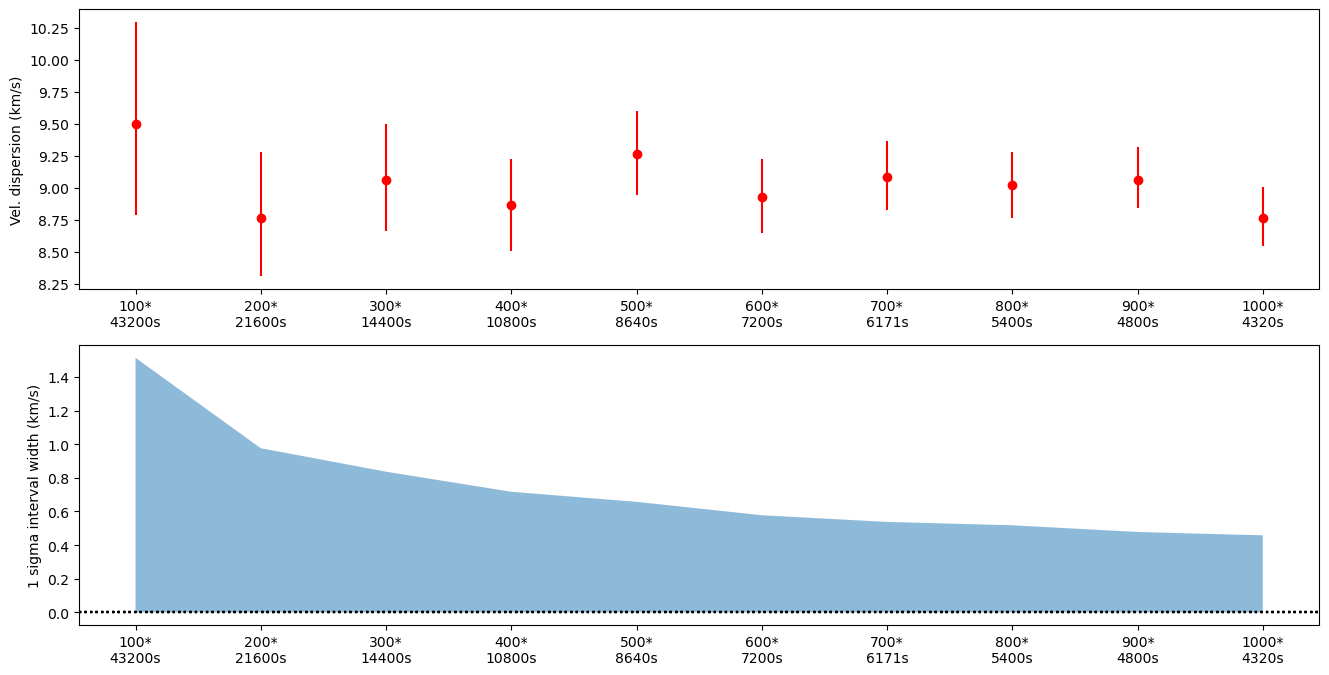

In [11]:
f,a=plt.subplots(2,figsize=(16,8))
tottime=12*3600
for i in range(len(nframes)):
    a[0].errorbar(nframes[i],sg_meds[i],yerr=[[sg_lwe[i]],[sg_upe[i]]],color='red',marker='o')
    a[0].set_xticks(nframes)
    
    #a[1].errorbar(nframes[i],0,yerr=[[sg_lwe[i]],[sg_upe[i]]],color='red',marker='o')
    a[1].axhline(0,linestyle='dotted',color='black')
    a[1].set_xticks(nframes)
a[0].set_ylabel("Vel. dispersion (km/s)")
a[0].set_xticklabels([f"{100*nframes[j]}*\n{tottime/nframes[j]:.0f}s" for j in range(len(nframes))])

a[1].fill_between(nframes,[0 for i in sg_lwe],sg_sigdif_,alpha=0.5)
a[1].set_ylabel("1 sigma interval width (km/s)")
a[1].set_xticklabels([f"{100*nframes[j]}*\n{tottime/nframes[j]:.0f}s" for j in range(len(nframes))])
plt.show()

So, here I've introduced this statistic, the "1 sigma interval width" as a measure of the spread of the velocity dispersion uncertainty. This is (value+upper uncertainty)-(value-lower uncertainty) and would be 2 times the uncertainty for a symmetric uncertainty. We can see that it decreases as we observe more stars.

It's not clear that this should necessarily be the case, if the falloff of stellar magnitudes was severe enough that attempting to observe additional stars led only to getting a worse error on our brightest stars.

# Fitting the Dispersion as a function of number of seperate observations

Let's specifically use the 1 sigma interval as a parameter for "dispersion uncertainty".

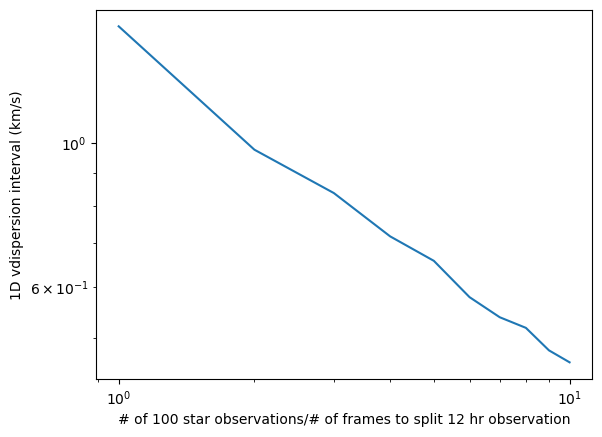

In [11]:
nfra=np.array(nframes)
sigdif=np.array(sg_sigdif_)

f,a=plt.subplots()
a.plot(nfra,sigdif)
a.set_xlabel('# of 100 star observations/# of frames to split 12 hr observation')
a.set_ylabel('1D vdispersion interval (km/s)')
a.set_yscale('log')
a.set_xscale('log')
plt.show()

# seems to have power law form

LinregressResult(slope=-0.5081416153325412, intercept=0.3789857171242964, rvalue=-0.9979227256259137, pvalue=8.125882170067034e-11, stderr=0.01159789393273434, intercept_stderr=0.019285398407577523)


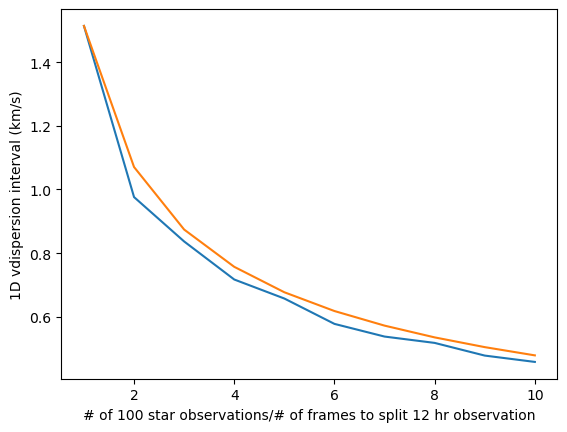

In [12]:
from scipy.stats import linregress
print(linregress(np.log(nfra),np.log(sigdif) ))
f,a=plt.subplots()
a.plot(nfra,sigdif)
a.plot(nfra,sigdif[0]/np.sqrt(nfra))
a.set_xlabel('# of 100 star observations/# of frames to split 12 hr observation')
a.set_ylabel('1D vdispersion interval (km/s)')
plt.show()

It seems that the relation is well explained as the error decreasing as the inverse square root of number of frames. We can relate the number of frames proportionally to the number of stars observed, so we initially comment that the uncertainty decreases more from increasing the number of points than it increases for observing for less time.

To take this apart, we can consider the case where we change only the observation time (without changing the # of stars observed) or where we change only the # of stars (for a single simulated observation, just truncating at different numbers of stars).

1
2
3
4
5
6
7
8
9
10


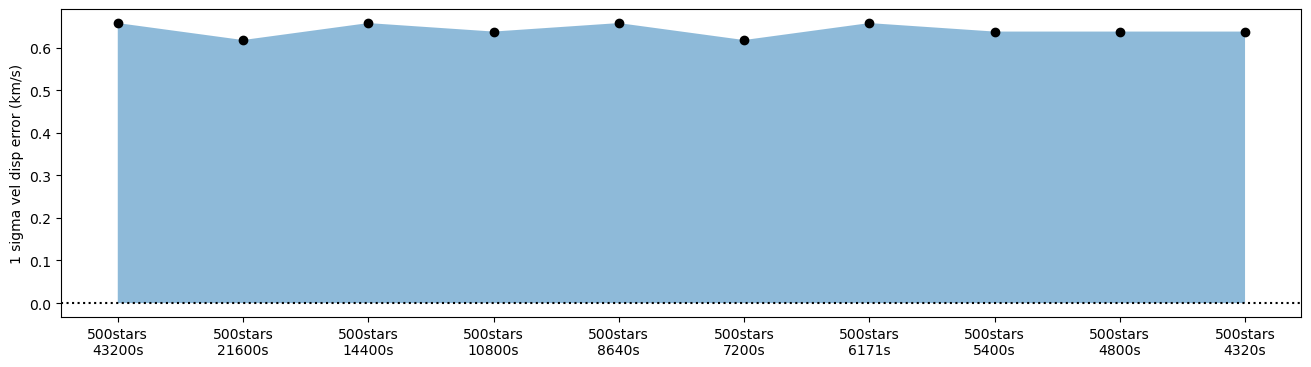

In [13]:
sg_upe=[]
sg_lwe=[]

nframes=[1,2,3,4,5,6,7,8,9,10]

npts=1000
mu_=np.linspace(40,80,npts)
sg_=np.linspace(0.1,20,npts)
mu,sg=np.meshgrid(mu_,sg_)

for no in nframes:
    print(no)
    temp_=np.loadtxt(f"instance/temp_{no}.txt")
    nancut=~np.any(np.isnan(temp_),axis=-1)
    temp_=temp_[nancut]
    temp=temp_[:500].T
    
    errors=temp[13]
    measvs=temp[10]

    #ignoring the constant first term which depends on the # of points but is constant for any particular data realization
    lnLi = [-0.5*np.log(sg**2+errors[i]**2)-0.5*(measvs[i]-mu)**2/(sg**2+errors[i]**2) for i in range(len(temp[13]))]
    lnLi=np.array(lnLi)
    lnL=np.sum(lnLi,axis=0)
    ind=np.unravel_index(lnL.argmax(), lnL.shape)
    lnL=lnL-lnL[ind]
    
    jpdf=np.exp(lnL)/np.sum(np.exp(lnL))/sg
    marg_sg=np.sum(jpdf,axis=1)
    
    cdf_sg=np.cumsum(marg_sg)/np.sum(marg_sg)

    sg_upe.append(sg_[np.argmin( (cdf_sg-0.841)**2)]-sg_[np.argmin( (cdf_sg-0.5)**2)])
    sg_lwe.append(sg_[np.argmin( (cdf_sg-0.5)**2)]-sg_[np.argmin( (cdf_sg-0.159)**2)])
    
sg_sigdif=[sg_lwe[i]+sg_upe[i] for i in range(len(sg_lwe))]
f,a=plt.subplots(1,figsize=(16,4))
tottime=12*3600

a.set_xticks(nframes)
a.axhline(0,linestyle='dotted',color='black')
a.fill_between(nframes,[0 for i in sg_lwe],sg_sigdif,alpha=0.5)
a.plot(nframes,sg_sigdif,marker='o',color='black',linewidth=0)

a.set_ylabel("1 sigma vel disp error (km/s)")
a.set_xticklabels([f"{500}stars\n{tottime/nframes[j]:.0f}s" for j in range(len(nframes))])
plt.show()

1
2
3
4
5
6
7
8
9
10


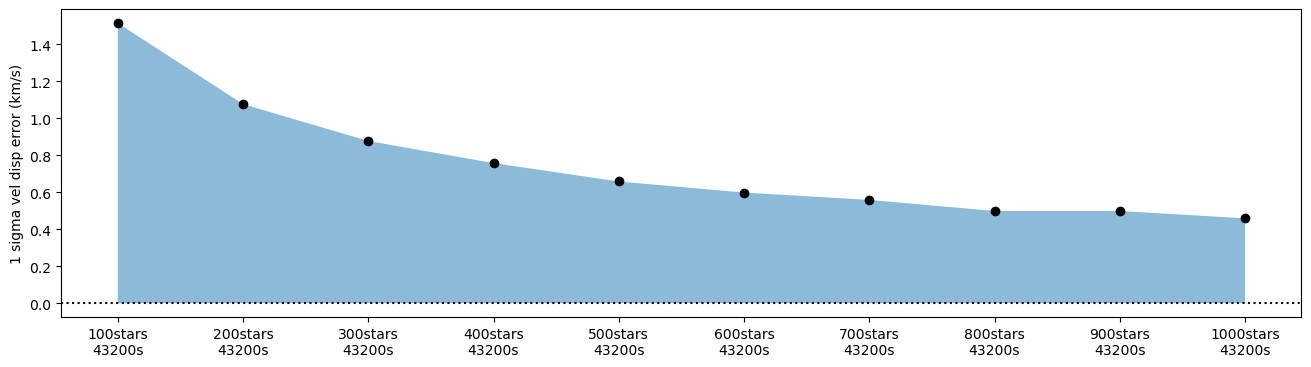

In [14]:
sg_upe=[]
sg_lwe=[]

nframes=[1,2,3,4,5,6,7,8,9,10]

npts=1000
mu_=np.linspace(40,80,npts)
sg_=np.linspace(0.1,20,npts)
mu,sg=np.meshgrid(mu_,sg_)

temp_=np.loadtxt(f"instance/temp_1.txt")
nancut=~np.any(np.isnan(temp_),axis=-1)
temp_=temp_[nancut]
for no in nframes:
    print(no)
    
    temp=temp_[:100*no].T
    
    errors=temp[13]
    measvs=temp[10]

    #ignoring the constant first term which depends on the # of points but is constant for any particular data realization
    lnLi = [-0.5*np.log(sg**2+errors[i]**2)-0.5*(measvs[i]-mu)**2/(sg**2+errors[i]**2) for i in range(len(temp[13]))]
    lnLi=np.array(lnLi)
    lnL=np.sum(lnLi,axis=0)
    ind=np.unravel_index(lnL.argmax(), lnL.shape)
    lnL=lnL-lnL[ind]
    
    jpdf=np.exp(lnL)/np.sum(np.exp(lnL))/sg
    marg_sg=np.sum(jpdf,axis=1)
    
    cdf_sg=np.cumsum(marg_sg)/np.sum(marg_sg)

    sg_upe.append(sg_[np.argmin( (cdf_sg-0.841)**2)]-sg_[np.argmin( (cdf_sg-0.5)**2)])
    sg_lwe.append(sg_[np.argmin( (cdf_sg-0.5)**2)]-sg_[np.argmin( (cdf_sg-0.159)**2)])
    
sg_sigdif=[sg_lwe[i]+sg_upe[i] for i in range(len(sg_lwe))]
f,a=plt.subplots(1,figsize=(16,4))
tottime=12*3600

a.set_xticks(nframes)
a.axhline(0,linestyle='dotted',color='black')
a.fill_between(nframes,[0 for i in sg_lwe],sg_sigdif,alpha=0.5)
a.plot(nframes,sg_sigdif,marker='o',color='black',linewidth=0)

a.set_ylabel("1 sigma vel disp error (km/s)")
a.set_xticklabels([f"{100*nframes[j]}stars\n{tottime/1:.0f}s" for j in range(len(nframes))])
plt.show()

It seems like this effect is dominated by the number of stars observed which I think is not actually that surprising of a result for a Draco-like galaxy which is very bright. I think the question is whether this trend would persist for a smaller galaxy, where the velocity dispersion uncertainties, especially due to observational effects are larger.

# Sorting by Magnitude

So the code doesn't generate the stars in any particular order (not ordered by radius, velocity, or magnitude) so truncating the simulation to the first $N$ stars gives us a "random selection" of $N$ stars. If we would like to think that velocity dispersion doesn't change with radius, then this might be similar to choosing spatially compact groups of stars. 

However, we could instead choose to prioritize brighter, lower-error stars over the fainter stars. Let us see the effect of this:

1
2
3
4
5
6
7
8
9
10


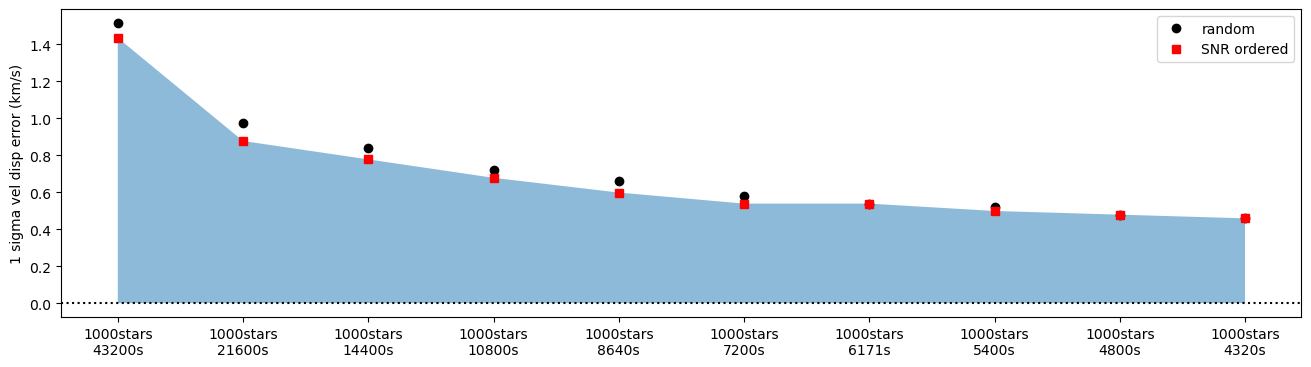

In [16]:
sg_upe=[]
sg_lwe=[]

nframes=[1,2,3,4,5,6,7,8,9,10]

npts=1000
mu_=np.linspace(40,80,npts)
sg_=np.linspace(0.1,20,npts)
mu,sg=np.meshgrid(mu_,sg_)

for no in nframes:
    print(no)
    temp_=np.loadtxt(f"instance/temp_{no}.txt")
    nancut=~np.any(np.isnan(temp_),axis=-1)
    temp_=temp_[nancut]
    
    # this is the step where we order the data by descending SNR so that the first ## of stars
    # is the top ## SNR stars
    
    temp_=temp_[np.argsort(temp_[:,6])[::-1]]
    
    temp=temp_[:no*100].T
    
    errors=temp[13]
    measvs=temp[10]

    #ignoring the constant first term which depends on the # of points but is constant for any particular data realization
    lnLi = [-0.5*np.log(sg**2+errors[i]**2)-0.5*(measvs[i]-mu)**2/(sg**2+errors[i]**2) for i in range(len(temp[13]))]
    lnLi=np.array(lnLi)
    lnL=np.sum(lnLi,axis=0)
    ind=np.unravel_index(lnL.argmax(), lnL.shape)
    lnL=lnL-lnL[ind]
    
    jpdf=np.exp(lnL)/np.sum(np.exp(lnL))/sg
    marg_sg=np.sum(jpdf,axis=1)
    
    cdf_sg=np.cumsum(marg_sg)/np.sum(marg_sg)

    sg_upe.append(sg_[np.argmin( (cdf_sg-0.841)**2)]-sg_[np.argmin( (cdf_sg-0.5)**2)])
    sg_lwe.append(sg_[np.argmin( (cdf_sg-0.5)**2)]-sg_[np.argmin( (cdf_sg-0.159)**2)])
    
sg_sigdif=[sg_lwe[i]+sg_upe[i] for i in range(len(sg_lwe))]
f,a=plt.subplots(1,figsize=(16,4))
tottime=12*3600

a.set_xticks(nframes)
a.axhline(0,linestyle='dotted',color='black')
a.fill_between(nframes,[0 for i in sg_lwe],sg_sigdif,alpha=0.5)
a.plot(nframes,sg_sigdif_,marker='o',color='black',linewidth=0,label='random')
a.plot(nframes,sg_sigdif,marker='s',color='red',linewidth=0,label='SNR ordered')

a.set_ylabel("1 sigma vel disp error (km/s)")
a.set_xticklabels([f"{nframes[j]*100}stars\n{tottime/nframes[j]:.0f}s" for j in range(len(nframes))])
a.legend()
plt.show()

Different but does not seem significantly different. Again, could make a larger difference for a smaller system.

# So let's do this a bunch of times

to make sure this is not an anomaly, we want to do this again and again, for each number of individual observations. This is 4 observations (=400 stars, 3 hour observations). The first plot displays the best fit velocity dispersions and their uncertainties for each of 100 simulations of a Draco-like galaxy.

Then from this ensemble, I've plotted the 1 sigma interval width below. The interpretation of that plot is that when generating (observing) a galaxy with a true dispersion of 9.1 km/s at this # of individual observations, we get a 1 sigma interval width of around 0.68. This gives us an idea of the distribution and typical spread of uncertainties that we get when doing this procedure.

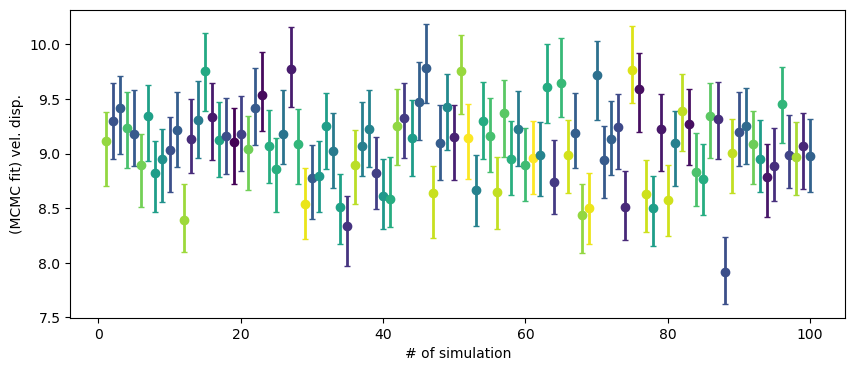

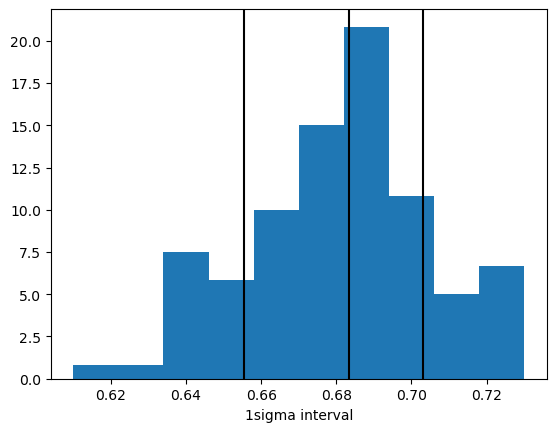

In [15]:
no=4
sigfile=np.loadtxt(f"dracotest/dracotest_1.0_IMACS_{no}.txt").T

# median sig # low sig # upper sigma # nstars # observing time
#    0       #.  1.    #.   2.       #. 3.    #.   4

med_sig=sigfile[0]
upp_sig=sigfile[0]-sigfile[1]
low_sig=sigfile[2]-sigfile[0]


f,ax=plt.subplots(figsize=(10,4))

a=ax
ine=range(len(sigfile[0]))
colors=plt.get_cmap('viridis')
ran=colors(np.random.rand(len(sigfile[0])))
for c in ine:
    a.errorbar([c+1],[med_sig[c]],yerr=[ [low_sig[c]] ,[upp_sig[c]] ],marker='o',linewidth=0,elinewidth=2,color=ran[c],capsize=2)
a.set_xlabel('# of simulation')
a.set_ylabel('(MCMC fit) vel. disp.')

'''
a2=ax[1]


a2.hist(med_sig,density=True,orientation="horizontal")
a2.errorbar(np.zeros(len(med_sig)),med_sig,yerr=[low_sig,upp_sig],alpha=0)
#a2.set_xlabel('1 sigma interval')
linez=np.percentile(med_sig,[15.9,50,84.1])
for l in linez:
    a2.axhline(l,color='black')
    a.axhline(l,color='black')
print(linez)
print(linez[1]-linez[0],linez[2]-linez[1])
plt.tight_layout()
'''
plt.show()
#print(low_sig)
#print(upp_sig)

int_sig=[(low_sig[i]+upp_sig[i]) for i in range(len(low_sig))]

f,a=plt.subplots()
a.hist(int_sig,density=True)
linez=np.percentile(int_sig,[15.9,50,84.1])
for l in linez:
    a.axvline(l,color='black')
a.set_xlabel('1sigma interval')
plt.show()

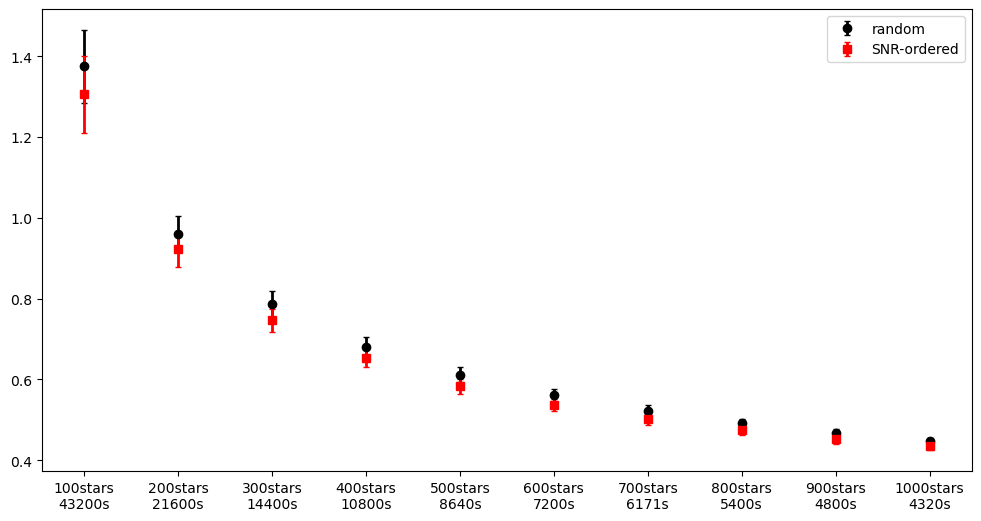

In [20]:
median=[]
lowers=[]
uppers=[]
ints=[]
ints_e=[]

medians=[]
lowerss=[]
upperss=[]
intss=[]
intss_e=[]

typic=[]
typics=[]
nframes=[1,2,3,4,5,6,7,8,9,10]

for no in nframes:
    sigfile=np.loadtxt(f"dracotest/dracotest_1.0_IMACS_{no}.txt").T

    med_sig=sigfile[0]
    upp_sig=sigfile[0]-sigfile[1]
    low_sig=sigfile[2]-sigfile[0]
    int_sig=low_sig+upp_sig

    linez=np.percentile(med_sig,[15.9,50,84.1])
    median.append(linez[1])
    lowers.append(linez[1]-linez[0])
    uppers.append(linez[2]-linez[1])
    typic.append(np.mean(np.mean(upp_sig**2+low_sig**2) ))
    ints.append(np.mean(int_sig) )
    ints_e.append(np.std(int_sig) )
    
    sigfiles=np.loadtxt(f"dracotest/dracotest_1.0_IMACS_{no}s.txt").T

    med_sigs=sigfiles[0]
    upp_sigs=sigfiles[0]-sigfiles[1]
    low_sigs=sigfiles[2]-sigfiles[0]
    int_sigs=low_sigs+upp_sigs


    linezs=np.percentile(med_sigs,[15.9,50,84.1])
    medians.append(linezs[1])
    lowerss.append(linezs[1]-linezs[0])
    upperss.append(linezs[2]-linezs[1])
    typics.append(np.mean(np.mean(upp_sigs**2+low_sigs**2) ))
    intss.append(np.mean(int_sigs) )
    intss_e.append(np.std(int_sigs) )
    

f,az=plt.subplots(1,figsize=(12,6))
a=az
tottime=12*3600

a.set_xticks(nframes)
#a.axhline(0,linestyle='dotted',color='black')
#a.fill_between(nframes,[0 for i in sg_lwe],sg_sigdif,alpha=0.5)
a.errorbar(nframes,ints,yerr=ints_e,marker='o',color='black',linewidth=0,elinewidth=2,capsize=2,label='random')
a.errorbar(nframes,intss,yerr=intss_e,marker='s',color='red',linewidth=0,elinewidth=2,capsize=2,label='SNR-ordered')
a.set_xticklabels([f"{nframes[j]*100}stars\n{tottime/nframes[j]:.0f}s" for j in range(len(nframes))])

a.legend()
plt.show()

[-0.47871512  1.33185075] [0.00552665 0.0141904 ]
[-0.46541956  1.24997516] [0.00853255 0.0203022 ]


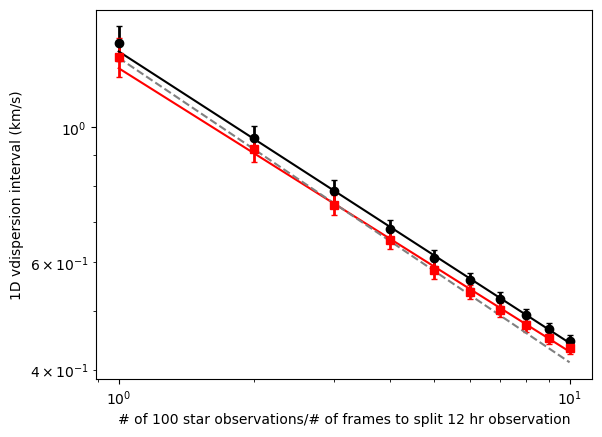

In [21]:
f,a=plt.subplots()
nfra=np.array(nframes)
sigdif=np.array(ints)
sigdife=np.array(ints_e)
sigdifs=np.array(intss)
sigdifse=np.array(intss_e)
a.errorbar(nfra,sigdif,sigdife,color='black',marker='o',label='random',linewidth=0,elinewidth=2,capsize=2)
a.errorbar(nfra,sigdifs,sigdifse,color='red',marker='s',label='SNR-ord',linewidth=0,elinewidth=2,capsize=2)

a.set_xlabel('# of 100 star observations/# of frames to split 12 hr observation')
a.set_ylabel('1D vdispersion interval (km/s)')
a.set_yscale('log')
a.set_xscale('log')

from scipy.optimize import curve_fit

def powerl(x,n,a):
    return a*(x**n)
             
q,qcov=curve_fit(powerl,nfra,sigdif,sigma=sigdife)
qe=np.sqrt(np.diag(qcov))
print(q,qe)
a.plot(nfra,q[1]*(nfra**q[0]),color='black' )

q,qcov=curve_fit(powerl,nfra,sigdifs,sigma=sigdifse)
qe=np.sqrt(np.diag(qcov))
print(q,qe)
a.plot(nfra,q[1]*(nfra**q[0]),color='red' )

a.plot(nfra,1.3*(nfra**-0.5),color='grey' ,linestyle='dashed')

plt.show()

# Testing for difference between these two cases

We cannot really perform a KS test on dependent variables like this, so a simpler statistic might be just seeing if the difference between each point is consistent with 0. Let us assume that these differences are given by a gaussian centered at zero and see what the best-fit spread is (perfect consistency with 0 would be a 0 spread).

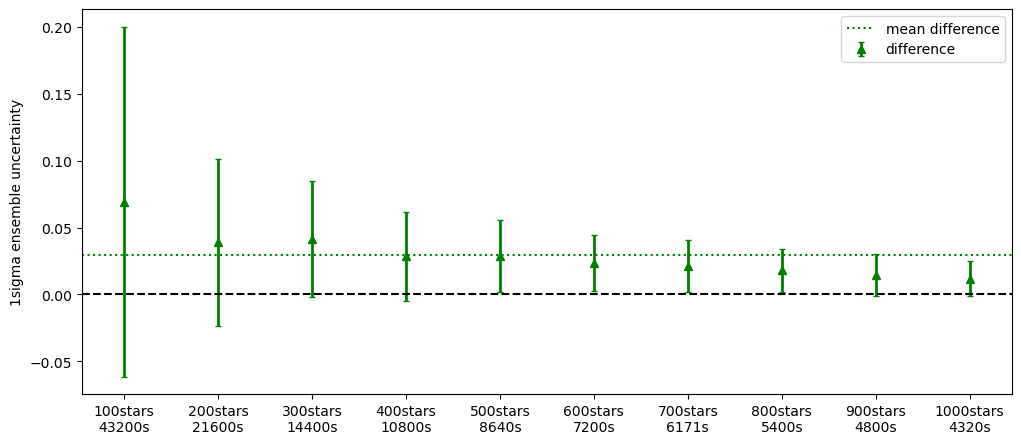

In [27]:
diiff=[ints[i]-intss[i] for i in range(len(nframes))]
diiff_e=[np.sqrt( ints_e[i]**2+intss_e[i]**2) for  i in range(len(nframes))]
f,a2=plt.subplots(1,figsize=(12,5))
tottime=12*3600
a2.errorbar(nframes,diiff,yerr=diiff_e,marker='^',color='green',linewidth=0,elinewidth=2,capsize=2,label='difference')
a2.axhline(0,color='black',linestyle='dashed')
a2.set_xticks(nframes)
a2.set_xticklabels([f"{(j+1)*100}stars\n{tottime/nframes[j]:.0f}s" for j in range(len(nframes))])
a2.set_ylabel('1sigma ensemble uncertainty')
a2.axhline(np.mean(diiff),color='green',linestyle='dotted',label='mean difference')
a2.legend()
plt.show()

Clear bias, SNR performs better for each case.

# So now a different example

Segue is a smaller galaxy (less stars) and DEIMOS has a larger systematic velocity (of 2 km/s) so let's see if these things play a difference. We are using a max stars per observation of 40 here.

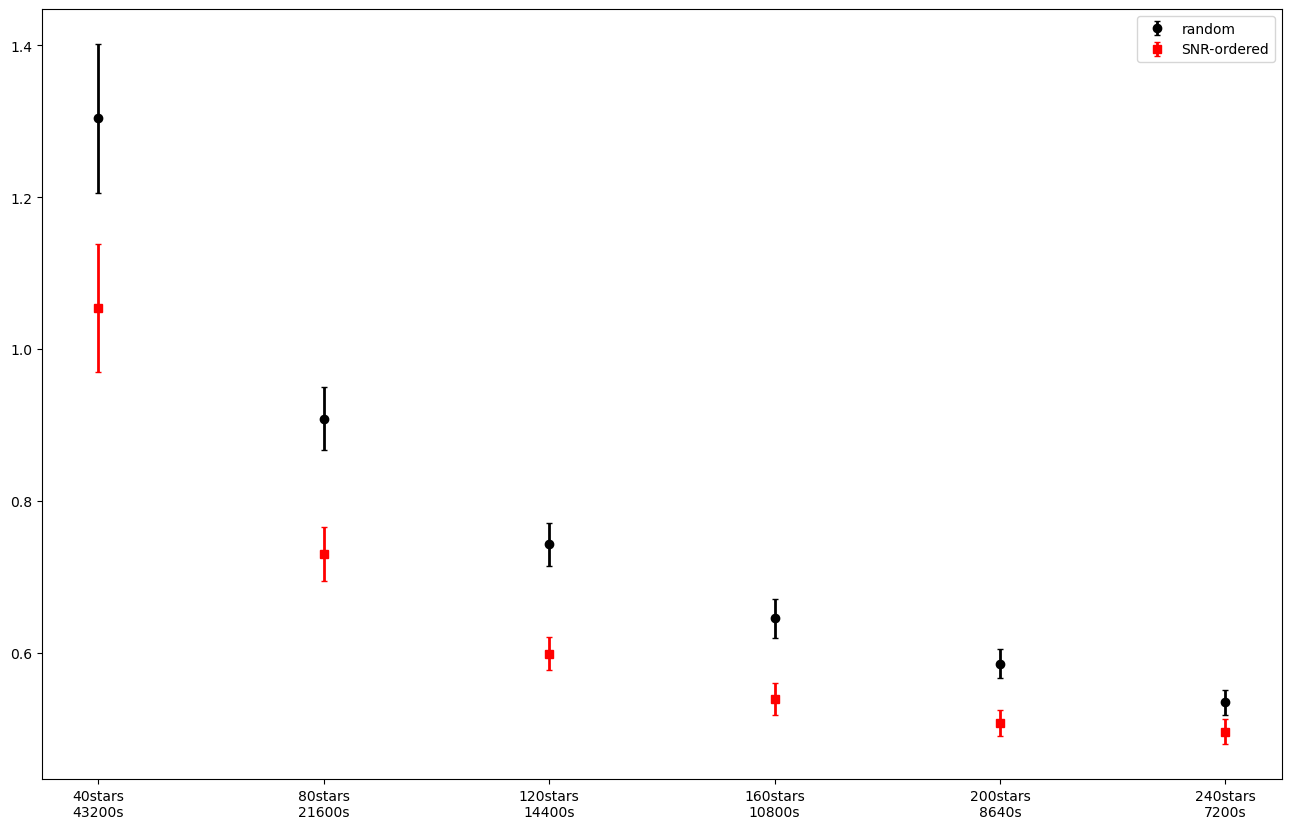

In [17]:
median=[]
lowers=[]
uppers=[]
ints=[]
ints_e=[]

medians=[]
lowerss=[]
upperss=[]
intss=[]
intss_e=[]

typic=[]
typics=[]
nframes=[1,2,3,4,5,6]

for no in nframes:
    sigfile=np.loadtxt(f"seguetest/seguetest_2.0_DEIMOS_{no}.txt").T

    med_sig=sigfile[0]
    upp_sig=sigfile[0]-sigfile[1]
    low_sig=sigfile[2]-sigfile[0]
    int_sig=low_sig+upp_sig

    linez=np.percentile(med_sig,[15.9,50,84.1])
    median.append(linez[1])
    lowers.append(linez[1]-linez[0])
    uppers.append(linez[2]-linez[1])
    typic.append(np.mean(np.mean(upp_sig**2+low_sig**2) ))
    ints.append(np.mean(int_sig) )
    ints_e.append(np.std(int_sig) )
    
    sigfiles=np.loadtxt(f"seguetest/seguetest_2.0_DEIMOS_{no}s.txt").T

    med_sigs=sigfiles[0]
    upp_sigs=sigfiles[0]-sigfiles[1]
    low_sigs=sigfiles[2]-sigfiles[0]
    int_sigs=low_sigs+upp_sigs


    linezs=np.percentile(med_sigs,[15.9,50,84.1])
    medians.append(linezs[1])
    lowerss.append(linezs[1]-linezs[0])
    upperss.append(linezs[2]-linezs[1])
    typics.append(np.mean(np.mean(upp_sigs**2+low_sigs**2) ))
    intss.append(np.mean(int_sigs) )
    intss_e.append(np.std(int_sigs) )
    

f,az=plt.subplots(1,figsize=(16,10))
a=az
tottime=12*3600

a.set_xticks(nframes)
#a.axhline(0,linestyle='dotted',color='black')
#a.fill_between(nframes,[0 for i in sg_lwe],sg_sigdif,alpha=0.5)
a.errorbar(nframes,ints,yerr=ints_e,marker='o',color='black',linewidth=0,elinewidth=2,capsize=2,label='random')
a.errorbar(nframes,intss,yerr=intss_e,marker='s',color='red',linewidth=0,elinewidth=2,capsize=2,label='SNR-ordered')
a.set_xticklabels([f"{nframes[j]*40}stars\n{tottime/nframes[j]:.0f}s" for j in range(len(nframes))])

a.legend()
plt.show()

[-0.4877318  1.2782477] [0.0071346  0.01299573]
[-0.38365592  0.94675253] [0.04206071 0.05623746]


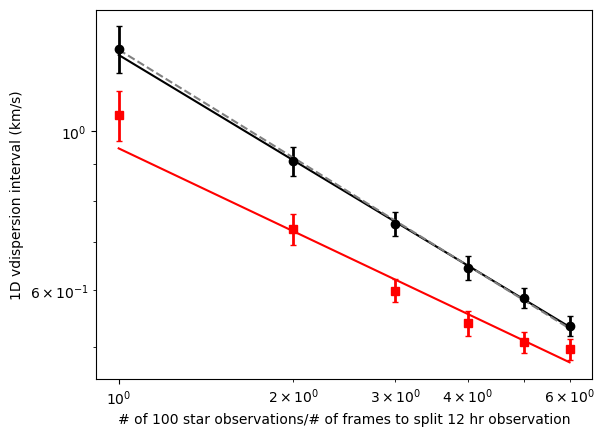

In [18]:
f,a=plt.subplots()
nfra=np.array(nframes)
sigdif=np.array(ints)
sigdife=np.array(ints_e)
sigdifs=np.array(intss)
sigdifse=np.array(intss_e)
a.errorbar(nfra,sigdif,sigdife,color='black',marker='o',label='random',linewidth=0,elinewidth=2,capsize=2)
a.errorbar(nfra,sigdifs,sigdifse,color='red',marker='s',label='SNR-ord',linewidth=0,elinewidth=2,capsize=2)

a.set_xlabel('# of 100 star observations/# of frames to split 12 hr observation')
a.set_ylabel('1D vdispersion interval (km/s)')
a.set_yscale('log')
a.set_xscale('log')

from scipy.optimize import curve_fit

def powerl(x,n,a):
    return a*(x**n)
             
q,qcov=curve_fit(powerl,nfra,sigdif,sigma=sigdife)
qe=np.sqrt(np.diag(qcov))
print(q,qe)
a.plot(nfra,q[1]*(nfra**q[0]),color='black' )

q,qcov=curve_fit(powerl,nfra,sigdifs,sigma=sigdifse)
qe=np.sqrt(np.diag(qcov))
print(q,qe)
a.plot(nfra,q[1]*(nfra**q[0]),color='red' )

a.plot(nfra,1.3*(nfra**-0.5),color='grey' ,linestyle='dashed')

plt.show()

Randomly selecting stars seems to lead to a very clear inverse square root relationship. It looks like the SNR selection falls below this kind of relationship.

Continue to More Fitting notebook.